# Simulate nightlight images from wealth

From previous research, we know that there is a correlation between nightlights and wealth ($y$), e.g. [Weidmann and Schutte 2017](https://kops.uni-konstanz.de/server/api/core/bitstreams/4d7666aa-1502-4281-8bb3-893d75b45268/content). We choose to represent this with a brightness factor:

$$
k = \frac{e^{\beta y} - 1}{e^{\beta} - 1}
$$

Where $\beta$ is a hyperparameter of our choice.

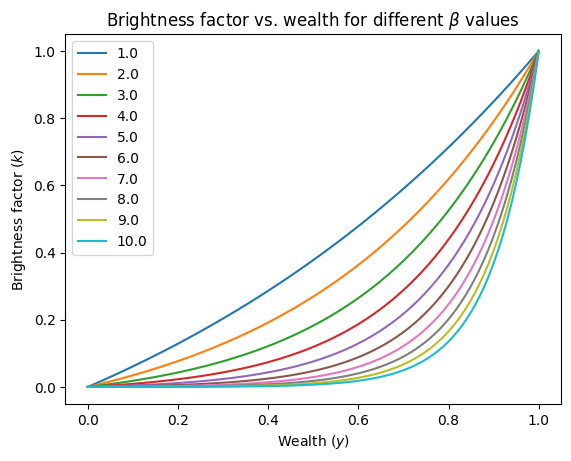

In [181]:
x = np.linspace(0, 1, 100)
for beta in np.linspace(1, 10, 10):
    y = (np.exp(beta * x) - 1) / (np.exp(beta) - 1)
    plt.plot(x, y, label=beta)
plt.legend()
plt.title(r'Brightness factor vs. wealth for different $\beta$ values')
plt.xlabel(r'Wealth ($y$)')
plt.ylabel(r'Brightness factor ($k$)')
plt.show()

A higher $\beta$ value gives a less linear relationship between wealth and brightness.

Using this relationship, we generate simulated nightlight images from Perlin noise

In [182]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def generate_nightlight_image(y, beta=2.5, size=(10, 10)):
    """
    Generate a simulated nightlight image M based on neighborhood wealth y in the range [0, 1].
    
    Parameters:
    - y: float, the neighborhood wealth value in [0, 1].
    - beta: float, the scaling factor for brightness growth with y.
    - size: (int, int), the size of the output image.

    Returns:
    - M: numpy array representing the nightlight intensity of each pixel.
    """
    # Calculate brightness factor with normalized exponential growth relationship
    brightness_factor = (np.exp(beta * y) - 1) / (np.exp(beta) - 1)
    
    # Get structured noise to simulate natural variation in light intensity
    # Generate Perlin-like smooth noise by filtering random noise
    noise = np.random.normal(brightness_factor, 1, size)
    M = gaussian_filter(noise, sigma=2)  # Smooth noise to create structure

    # Clip to ensure values stay within realistic intensity range
    M = np.clip(M, 0, 1)
    
    return M

Show some examples

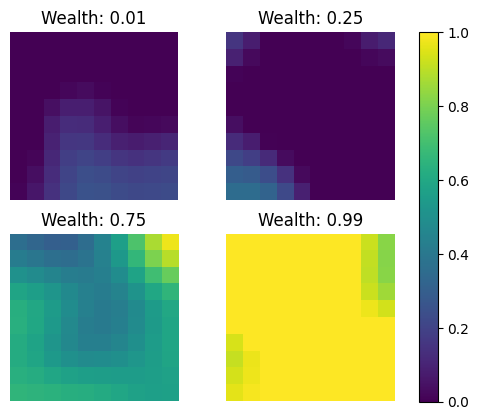

In [186]:
b=2.5

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
y = 0.01  # Example wealth level
M = generate_nightlight_image(y, beta=b, size=(10, 10))
ax1.title.set_text(f'Wealth: {y:.2f}')
ax1.imshow(M, vmin=0, vmax=1)
ax1.axis('off')

y = 0.25  # Example wealth level
M = generate_nightlight_image(y, beta=b, size=(10, 10))
ax2.imshow(M, vmin=0, vmax=1)
ax2.title.set_text(f'Wealth: {y:.2f}')
ax2.axis('off')

y = 0.75  # Example wealth level
M = generate_nightlight_image(y, beta=b, size=(10, 10))
ax3.imshow(M, vmin=0, vmax=1)
ax3.title.set_text(f'Wealth: {y:.2f}')
ax3.axis('off')

y = 0.99  # Example wealth level
M = generate_nightlight_image(y, beta=b, size=(10, 10))
im = ax4.imshow(M, vmin=0, vmax=1)
ax4.title.set_text(f'Wealth: {y:.2f}')
ax4.axis('off')
fig.colorbar(im, ax=(ax1, ax2, ax3, ax4))
plt.show()

Generate a set of samples

In [159]:
N = 10000
Ms = []
ys = []

for _ in range(N):
    y = np.random.uniform(0, 1)
    M = generate_nightlight_image(y, beta=b)
    Ms.append(M)
    ys.append(y)
    
Ms = np.stack(Ms)
ys = np.asarray(ys)

Text(0.5, 0, 'Wealth')

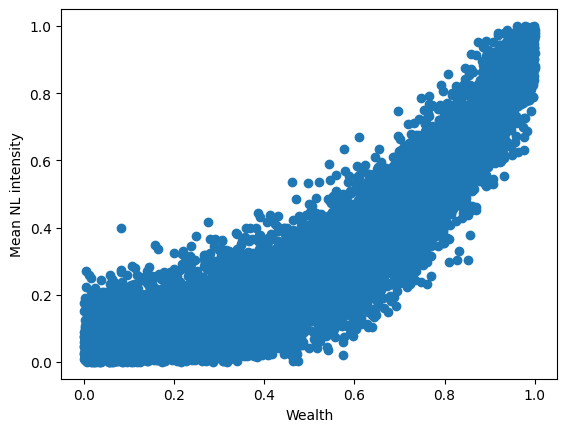

In [163]:
plt.scatter(ys, np.mean(Ms, axis=(1,2)))
plt.ylabel('Mean NL intensity')
plt.xlabel('Wealth')

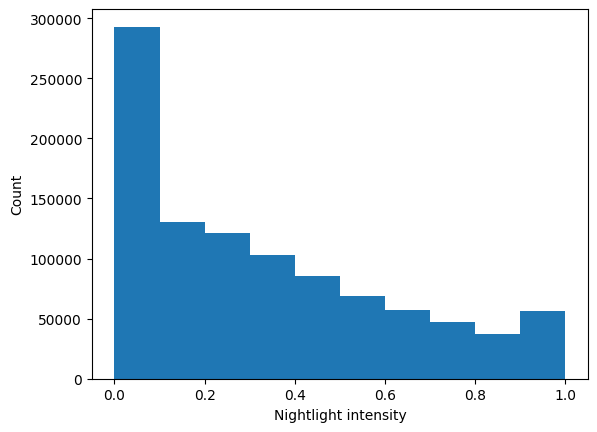

In [179]:
plt.hist(Ms.flatten())
plt.xlabel('Nightlight intensity')
plt.ylabel('Count')
plt.show()

For each sample, create a 1D histogram with brightness values

In [164]:
# Number of histogram bins
num_bins = 20
bins = np.linspace(0, 1, num_bins + 1)

# Create histograms for each image
histograms = []
for M in Ms:
    hist, _ = np.histogram(M, bins=bins)
    histograms.append(hist)

histograms = np.stack(histograms)  # (n, num_bins)

Fit a random forest regressor to estimate wealth from these histogram

In [165]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(histograms, ys, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the random forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2:", r2)

Mean Squared Error: 0.01407251333619611
R^2: 0.8316943621506668


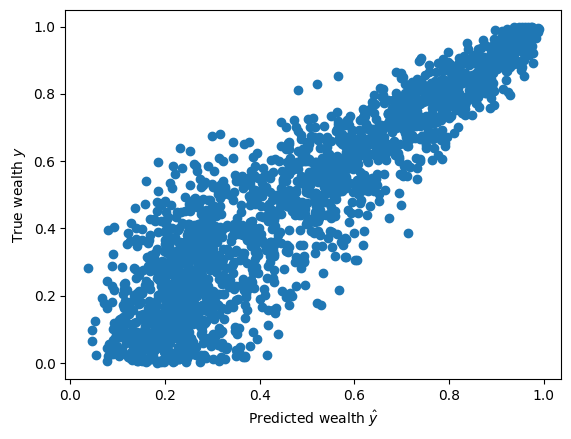

In [188]:
plt.scatter(y_pred, y_test)
plt.xlabel(r'Predicted wealth $\hat{y}$')
plt.ylabel(r'True wealth $y$')
plt.show()